In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from collections import defaultdict

# Data Preparation

In [3]:
df = pd.read_csv('/Users/samuele/University/2.DM2/fma_metadata/echo_popelec.csv')
df.set_index('track_id', inplace=True)
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.963590,111.562,161,192,Pop
213,0.933741,0.312720,0.340999,0.919242,0.082976,0.032745,0.043054,142.499,247,256,Pop
384,0.444822,0.561166,0.700912,0.817286,0.111111,0.036441,0.344763,91.077,249,256,Electronic
386,0.436375,0.585549,0.782927,0.894428,0.142187,0.047893,0.301543,130.464,357,256,Electronic
387,0.464508,0.493599,0.552749,0.736318,0.110117,0.055116,0.221480,136.255,326,256,Electronic


# Data Partitioning

In [4]:
attributes = [col for col in df.columns if col != 'genre_top']

train, test = train_test_split(df, test_size=.33, random_state=42)

X_test = df[attributes]
y_test = df['genre_top']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [5]:
# encoding labels
le = preprocessing.LabelEncoder()
y_test_enc = ~le.fit_transform(test['genre_top']).astype('bool')

In [6]:
df['genre_top'].value_counts()

Electronic    2049
Pop            337
Name: genre_top, dtype: int64

# RIPPER

https://github.com/imoscovitz/wittgenstein

In [7]:
import wittgenstein as lw

In [8]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        clf = lw.RIPPER(random_state=42, prune_size=pr)
        clf.fit(train, class_feat='genre_top', pos_class='Electronic')
        y_predicted = clf.predict(test)
        print("prune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))

prune_size:  0.1
              precision    recall  f1-score   support

       False       0.28      0.59      0.38       119
        True       0.91      0.73      0.81       669

    accuracy                           0.71       788
   macro avg       0.59      0.66      0.59       788
weighted avg       0.81      0.71      0.74       788

prune_size:  0.2
              precision    recall  f1-score   support

       False       0.31      0.55      0.40       119
        True       0.91      0.78      0.84       669

    accuracy                           0.75       788
   macro avg       0.61      0.67      0.62       788
weighted avg       0.82      0.75      0.77       788

prune_size:  0.3
              precision    recall  f1-score   support

       False       0.31      0.64      0.42       119
        True       0.92      0.75      0.82       669

    accuracy                           0.73       788
   macro avg       0.61      0.69      0.62       788
weighted avg       0.83

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

In [9]:
clf = lw.RIPPER(random_state=42, prune_size=0.6)
clf.fit(train, class_feat='genre_top', pos_class='Electronic')

In [10]:
y_predicted = clf.predict(test)
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.33      0.55      0.42       119
        True       0.91      0.80      0.85       669

    accuracy                           0.76       788
   macro avg       0.62      0.68      0.63       788
weighted avg       0.82      0.76      0.79       788



In [11]:
clf.out_model()

[[bit_rate=160-192 ^ duration=33-121] V
[valence=0.02-0.06] V
[instrumentalness=0.93-0.95 ^ bit_rate=256-320] V
[bit_rate=160-192] V
[speechiness=0.08-0.12] V
[speechiness=0.2-0.65] V
[speechiness=0.07-0.08] V
[speechiness=0.12-0.2] V
[instrumentalness=0.86-0.89] V
[instrumentalness=0.83-0.86] V
[instrumentalness=0.76-0.83] V
[tempo=85.28-93.94] V
[energy=0.94-1.0]]


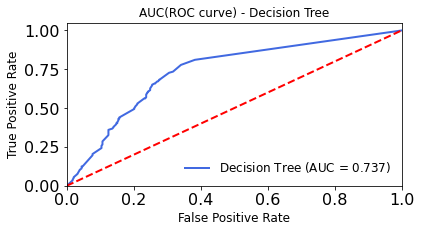

In [12]:
plt.figure(figsize=(6,3))

# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1], pos_label='Electronic')

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='royalblue', lw=2, label='Decision Tree$\;$(AUC = %.3f)' % roc_auc0)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('AUC(ROC curve) - Decision Tree', fontsize=12)
plt.legend(loc="lower right", fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
True: Jazz
False: Rock
[[ 66  53]
 [133 536]]


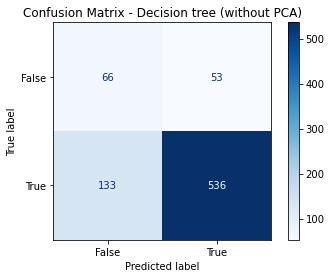

In [13]:
print("Legend:\nTrue: Jazz"
      "\nFalse: Rock")
cm = plot_confusion_matrix(clf,test,y_test_enc,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

# IREP

In [14]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        irep_clf = lw.IREP(random_state=42, prune_size=pr)
        irep_clf.fit(train, class_feat='genre_top', pos_class='Electronic')
        y_predicted = irep_clf.predict(test)
        print("\nprune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))


prune_size:  0.1
              precision    recall  f1-score   support

       False       0.31      0.61      0.41       119
        True       0.92      0.76      0.83       669

    accuracy                           0.74       788
   macro avg       0.61      0.68      0.62       788
weighted avg       0.82      0.74      0.77       788


prune_size:  0.2
              precision    recall  f1-score   support

       False       0.47      0.35      0.40       119
        True       0.89      0.93      0.91       669

    accuracy                           0.84       788
   macro avg       0.68      0.64      0.66       788
weighted avg       0.83      0.84      0.83       788


prune_size:  0.3
              precision    recall  f1-score   support

       False       0.44      0.27      0.34       119
        True       0.88      0.94      0.91       669

    accuracy                           0.84       788
   macro avg       0.66      0.60      0.62       788
weighted avg       0

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



prune_size:  1
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       119
        True       0.85      1.00      0.92       669

    accuracy                           0.85       788
   macro avg       0.42      0.50      0.46       788
weighted avg       0.72      0.85      0.78       788



irep.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is universal. All predictions it makes with method .predict will be positive. It may be untrained or was trained on a dataset split lacking negative examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is universal. All predictions it makes with method .predict will be positive. It may be untrained or was trained on a dataset split lacking negative examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

In [19]:
irep_clf = lw.IREP(random_state=42, prune_size=0.1)
irep_clf.fit(train, class_feat='genre_top', pos_class='Electronic')

In [20]:
y_predicted = irep_clf.predict(test)

In [21]:
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.31      0.61      0.41       119
        True       0.92      0.76      0.83       669

    accuracy                           0.74       788
   macro avg       0.61      0.68      0.62       788
weighted avg       0.82      0.74      0.77       788



In [22]:
irep_clf.out_model()

[[bit_rate=160-192] V
[instrumentalness=0.93-0.95] V
[instrumentalness=0.83-0.86] V
[valence=0.02-0.06] V
[energy=0.94-1.0] V
[speechiness=0.07-0.08] V
[speechiness=0.12-0.2] V
[speechiness=0.08-0.12] V
[speechiness=0.2-0.65] V
[instrumentalness=0.86-0.89]]


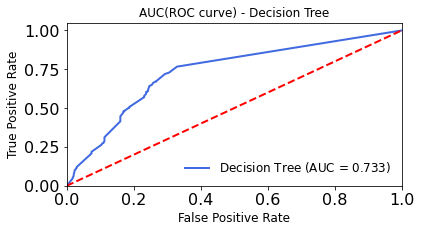

In [25]:
plt.figure(figsize=(6,3))

# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = irep_clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1], pos_label='Electronic')

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='royalblue', lw=2, label='Decision Tree$\;$(AUC = %.3f)' % roc_auc0)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('AUC(ROC curve) - Decision Tree', fontsize=12)
plt.legend(loc="lower right", fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
True: Jazz
False: Rock
[[ 72  47]
 [159 510]]


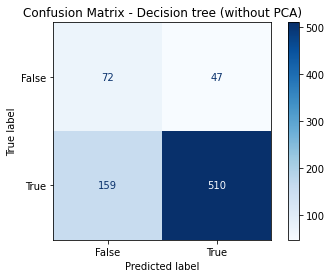

In [26]:
print("Legend:\nTrue: Jazz"
      "\nFalse: Rock")
cm = plot_confusion_matrix(irep_clf,test,y_test_enc,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()